In [ ]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

In [39]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import functools
#from dask.diagnostics.progress import ProgressBar
import scipy
import petl as ptl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [3]:
#Mounting Google Drive
import os
import glob
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [4]:
plt.rcdefaults()
sns.reset_defaults()
rcParams = plt.rcParams
base_font_size = 12
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = 13
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
#rcParams['savefig.jpeg_quality'] = 100
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.facecolor'] = 'w'

In [5]:
ag3 = malariagen_data.Ag3()
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140",
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
#bf_samples = df_samples.query('country == "Burkina Faso"')

/usr/local/lib/python3.10/dist-packages/malariagen_data/util.py:913: UserWarning:  Your currently allocated Google Colab VM is not located in the US.
This usually means that data access will be substantially slower. If
possible, select "Runtime > Disconnect and delete runtime" from the
menu to request a new VM and try again.
  warnings.warn(


In [6]:
bf_samp = df_samples.query('country == "Burkina Faso"')
bf_samp.groupby(['location','aim_species']).size()

location        aim_species                  
Bana Market     coluzzii                         181
                gambiae                            8
Bana Village    arabiensis                         1
                coluzzii                         308
                gambiae                           84
                intermediate_gambiae_coluzzii      1
Monomtenga      gambiae                           13
Pala            arabiensis                       113
                coluzzii                          11
                gambiae                          302
                intermediate_gambiae_coluzzii      1
Souroukoudinga  arabiensis                         1
                coluzzii                         243
                gambiae                          155
dtype: int64

In [7]:
from collections import Counter

#Create population column
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, s3, y, sp_y, pop_labels, pop_colors, sp_labels, sp_colors = [], [], [], [], [], {}, {}, {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

# Pop_year
for pop, year in zip(bf_samples.population, bf_samples.year):
    y.append(pop+'_'+str(year))
bf_samples.insert(5, 'pop_year', y)
pop_year = list(bf_samples.pop_year.unique())

# Species_year
for species, year in zip(bf_samples.aim_species, bf_samples.year):
    sp_y.append(species+'_'+str(year))
bf_samples.insert(6, 'species_year', sp_y)
species_year = list(bf_samples.species_year.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:4]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#sp labels
for year, species in zip(bf_samples.year, bf_samples.aim_species):
  s3.append(str(year)+' $An.'+species)
val = list(Counter(s3).keys())
for idx, vl in zip(species_year, val):
    sp_labels[idx]=vl
sp_labels

#pop_labels color
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

#sp_labels color
colored = sns.color_palette("husl", len(species_year))
for i in range(len(species_year)):
    sp_colors[species_year[i]] = colored[i]

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
coh_pop_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['pop_year'])])
coh_species_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['species_year'])])

#remove some populations
pop_rm = ['Bana_ara', 'Bana_int', 'Sour_ara',  'Pala_col', 'Pala_int']
pop_year_rm = ['Bana_col_2012', 'Bana_col_2014', 'Bana_col_2015', 'Bana_col_2016',
               'Bana_col_2017', 'Bana_gam_2012', 'Bana_gam_2014', 'Bana_gam_2015', 'Bana_gam_2016',
               'Pala_ara_2014', 'Pala_ara_2015', 'Pala_ara_2016', 'Pala_col_2012',
               'Pala_gam_2012', 'Pala_gam_2014', 'Pala_gam_2015', 'Pala_gam_2016', 'Pala_gam_2017',
               'Sour_col_2012', 'Sour_col_2014', 'Sour_col_2015', 'Sour_col_2016',
               'Sour_col_2017', 'Sour_gam_2012', 'Sour_gam_2014', 'Sour_gam_2015', 'Sour_gam_2016']
del s1, s2, y, val, colored, sp_y
pop_species_year = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016', 'arabiensis_2017',
                    'coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017',
                    'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']
pop_species_year_select = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016','coluzzii_2012',
                           'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017',
                           'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']

# remove pop_function
def remove_pop(list1, list2):
  for item in list2:
    list1.remove(item)
  return list1
pop_coh = remove_pop(pop_ids.copy(), pop_rm)

<ipython-input-7-da036d63579e>:52: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
<ipython-input-7-da036d63579e>:53: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['pop_year'])])
<ipython-input-7-da036d63579e>:54: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_species_yea

In [8]:
# import data 3R data
#df = pd.DataFrame()
#files = glob.glob('drive/MyDrive/Genomic/Fst/data_fst/3R_*.csv')
#for f in files:
#  csv_files = pd.read_csv(f)
#  df = df.append(csv_files)

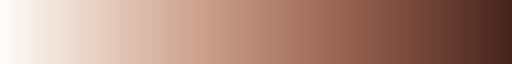

In [9]:
color = sns.color_palette("ch:s=4,rot=0.05,dark=0.18,light=0.99", as_cmap=True)
color

# Fonction to import Fst data

In [10]:
#def import_data(path='drive/MyDrive/Genomic/Haplotype_statistics/data_haps_h12', file='3R'):
#  df = pd.DataFrame()
#  files = glob.glob(f'{path}/{file}_*.csv')
#  for idx in range(len(files)):
#    csv_files = pd.read_csv(files[idx])
#    it = files[idx].split('_')[3]
#    sp_list = [it for i in range(len(csv_files.year_Pop))]
#    csv_files.insert(2,'sp_pop', sp_list)
#    df = df.append(csv_files)
#  return df


#def load_fst_np(file='3R_yty_fst_gambiae.npy'):
#  return np.load(f'drive/MyDrive/Genomic/Fst/data_fst/{file}')

#def Nm(fst):
#  return (0.25)*((1/fst)-1)

In [11]:
def import_data(path='drive/MyDrive/Genomic/Haplotype_statistics/data_haps_h12', file='3R'):
  #df = pd.DataFrame()
  tab_list = []
  files = glob.glob(f'{path}/{file}_*.csv')
  for idx in range(len(files)):
    csv_files = pd.read_csv(files[idx])
    it = files[idx].split('_')[3]
    sp_list = [it for i in range(len(csv_files.year_Pop))]
    csv_files.insert(2,'sp_pop', sp_list)
    tab_list.append(csv_files)
  #concat table
  df=pd.concat(tab_list)
  return df

def load_fst_np(file='3R_yty_fst_gambiae.npy'):
  return np.load(f'drive/MyDrive/Genomic/Fst/data_fst/{file}')

def Nm(fst):
  return (0.25)*((1/fst)-1)

# Import iwindow Fst data

In [12]:
# Import window Fst data
fst_stat_3L = import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='3L').reset_index()[['wind_mean', 'sp_pop', 'year_Pop', 'pair_fst']]
fst_stat_3R = import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='3R').reset_index()[['wind_mean', 'sp_pop', 'year_Pop', 'pair_fst']]
fst_stat_2L = import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='2L').reset_index()[['wind_mean', 'sp_pop', 'year_Pop', 'pair_fst']]
fst_stat_2R = import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='2R').reset_index()[['wind_mean', 'sp_pop', 'year_Pop', 'pair_fst']]
fst_stat_X = import_data(path='drive/MyDrive/Genomic/Fst/data_fst', file='X').reset_index()[['wind_mean', 'sp_pop', 'year_Pop', 'pair_fst']]

In [13]:
sns.light_palette((50, 90, 60), input="husl")

[(0.9515155226477457, 0.941995156410995, 0.9343884956380453),
 (0.9100958264030072, 0.8586178451225925, 0.7814727828351696),
 (0.8686761301582687, 0.7752405338341902, 0.628557070032294),
 (0.8272564339135303, 0.6918632225457879, 0.4756413572294183),
 (0.7858367376687918, 0.6084859112573855, 0.3227256444265426),
 (0.7444170414240533, 0.5251085999689832, 0.16980993162366703)]

In [14]:
sns.color_palette("Paired")
color_2 = sns.color_palette("ch:s=16,rot=0.05,dark=0.18,light=0.99", as_cmap=True)


In [15]:
ti = {'2':23, '3':'o'}
ti['2']

23

# Function to plot Fst

In [16]:
def plot_pairwise_fst(fst, Nem, pop_coh, pop_labels, figsize=(7, 4), xlabel=None, ylabel=None, mask=True,
                      ax=None, chrom='2L', fmt='.4f',fig_name=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=False, bottom=True, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((50, 90, 60), input="husl")),
                mask=mask, cbar=False, annot=True, fmt=f'{fmt}', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(Nem)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    #data = abs(data)
    #data[data > 100] = 100
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(abs(data), ax=ax, vmin=0, vmax=100, cmap='Greys',
                mask=mask, cbar=False, annot=True, fmt='.2f')

    # set ticks
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    ax.set_ylabel('$Ne.m$')
    ax.set_xlabel(f'Chromosome {chrom}' + r' - $F_{ST}$')
    ax.yaxis.set_label_position('right')

    # xticks
    if xlabel==True:
      ax.xaxis.tick_top()
      ax.set_xticks(np.arange(len(xtl)) + .5)
      ax.set_xticklabels( xtl, rotation=30, ha='left', fontweight='bold', fontstyle='italic')
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_xticklabels('')
      ax.set_xticks([])
    # yticks
    if ylabel==True:
      ax.set_yticklabels(ytl, rotation=0, ha='right', fontweight='bold', fontstyle='italic')
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_yticklabels('')
      ax.set_yticks([])

    # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight')

In [17]:
def plot_pairwise_fst1(fst, pop_coh, pop_labels, figsize=(4, 4), xlabel=None, ylabel=None, mask=True,
                      ax=None, chrom='2L', fs=10, fmt='.4f',fig_name=None):

    plt.rcdefaults()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=True, bottom=False, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((50, 90, 60), input="husl")),square=True,
                mask=mask, cbar=False, annot=True, fmt=f'{fmt}', linewidths=.5,)

    # set ticks
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    #ax.set_ylabel('$Ne.m$')
    #ax.set_xlabel(f'Chromosome {chrom}' + r' - $F_{ST}$')
    #ax.xaxis.set_label_position('top')
    #ax.yaxis.set_label_position('right')

    # xticks
    if xlabel==True:
      ax.xaxis.tick_bottom()
      ax.set_xticks(np.arange(len(xtl)) + .5)
      ax.set_xticklabels(xtl, rotation=30, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_xticklabels('')
      ax.set_xticks([])
    # yticks
    if ylabel==True:
      ax.set_yticklabels(ytl, rotation=0, ha='right', fontstyle='italic', fontsize=fs)
      ax.tick_params(length=0, pad=3)
    else:
      ax.set_yticklabels('')
      ax.set_yticks([])

      # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}1.png", dpi=300, bbox_inches='tight',transparent=False)


In [18]:
def plot_fst_year(data, figsize=(12,4), ax=None, title = None, xlab=None, ylab=None, legend_loc=None, fig_name=None):

  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, offset=5)

  #Plot fst
  sns.lineplot(x = 'wind_mean', y = 'pair_fst', hue='year_Pop', data=data, ax=ax,  linewidth=.5)

  # set ax title
  if title:
    ax.set_title (title = f'{title}')
  if xlab:
    ax.set_xlabel(f'{xlab}')
  if ylab:
    ax.set_ylabel(f'{ylab}')

  #set legend
  if legend_loc:
    ax.legend(loc='best', bbox_to_anchor=legend_loc)

  # set ax lim
  xlim1 = list(data.wind_mean)
  xlim=[xlim1[0], xlim1[-1]]
  ax.set_ylim(0,0.25)
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

  # Save fig
  if fig_name:
    fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight')

In [72]:
# Compute the figure of sequence divergence
def fig_Fst(data, title=None,  ax=None, color=None, ylab=None, xlab=None, fig_name=None):
  #define ax
  if ax is None:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=5)

  # make plot
  x, y =  data.wind_mean, data.pair_fst

  ax.plot(x, y, linestyle='-', color=color, linewidth=1)
  # Plot title
  if title:
    ax.set_title(f'{title}')

  # Customize plot
  if ylab:
    ax.set_ylabel('$F_{ST}$ ')
  if xlab:
    ax.set_xlabel(f'Chromosome {xlab} (pb)')

  #ax setting
  ax.set_ylim(0,0.25)
  leg=list(data.year_Pop.unique())
  leg1=leg[0].split('fst')
  ax.legend([r'$F_{ST}$' + leg1[1]+f'  -  {xlab}'], loc='upper left')
  xlim=(list(x)[0], list(x)[-1])
  ax.set_xlim(*xlim, auto=True)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])



In [73]:
#dt = list(fst_stat_2R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"').year_Pop.unique())
#tf = dt[0].split('fst')
#tf

# Chrom Fst

In [20]:
# Import chrom Fst data
fst_2R = load_fst_np(file='2R_fst.npy')
fst_2L = load_fst_np(file='2L_fst.npy')
fst_3R = load_fst_np(file='3R_fst.npy')
fst_3L = load_fst_np(file='3L_fst.npy')
fst_X = load_fst_np(file='X_fst.npy')

In [21]:
dt = np.round(list(abs(Nm(fst_2R[0]))),2)

dt1 = ['>100' if i>100 else str(i) for i in dt]
dt1
dt2 = scipy.spatial.distance.squareform(np.array(dt1))
dt2

array([['', '1.8', '0.38', '1.75', '>100', '1.76'],
       ['1.8', '', '0.53', '>100', '1.79', '>100'],
       ['0.38', '0.53', '', '0.5', '0.38', '0.53'],
       ['1.75', '>100', '0.5', '', '1.74', '>100'],
       ['>100', '1.79', '0.38', '1.74', '', '1.75'],
       ['1.76', '>100', '0.53', '>100', '1.75', '']], dtype='<U4')

In [22]:
data = list(scipy.spatial.distance.squareform(np.array(Nm(fst_2R[0]))))
data

[array([ 0.00000000e+00,  1.79938354e+00,  3.79534850e-01,  1.74947472e+00,
        -2.78420553e+03,  1.76105429e+00]),
 array([ 1.79938354e+00,  0.00000000e+00,  5.31801821e-01,  4.72865714e+03,
         1.79042313e+00, -8.17550707e+02]),
 array([0.37953485, 0.53180182, 0.        , 0.50029121, 0.37662263,
        0.5255265 ]),
 array([1.74947472e+00, 4.72865714e+03, 5.00291210e-01, 0.00000000e+00,
        1.74020333e+00, 1.35683523e+03]),
 array([-2.78420553e+03,  1.79042313e+00,  3.76622635e-01,  1.74020333e+00,
         0.00000000e+00,  1.75197495e+00]),
 array([ 1.76105429e+00, -8.17550707e+02,  5.25526498e-01,  1.35683523e+03,
         1.75197495e+00,  0.00000000e+00])]

## Plot Fst

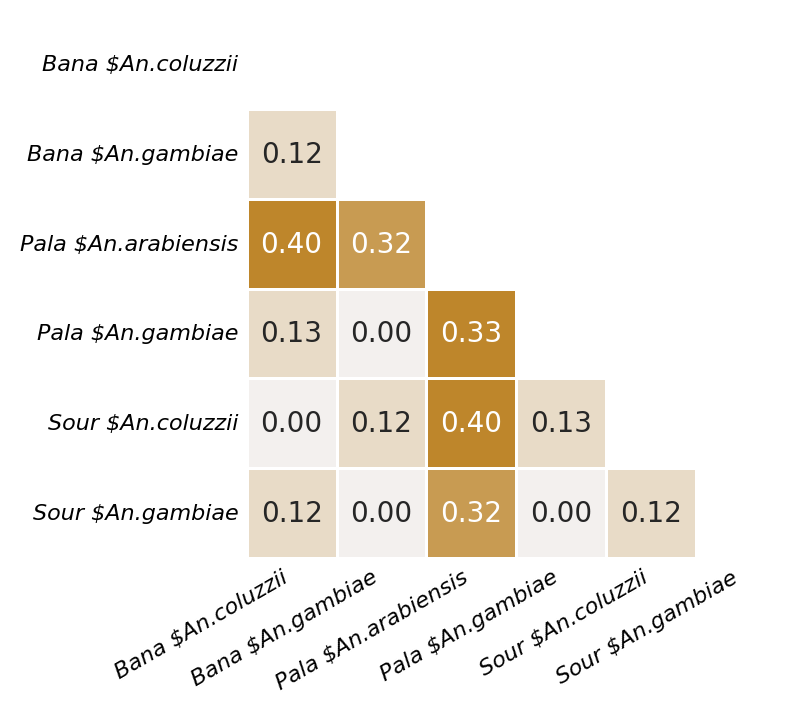

In [47]:
plot_pairwise_fst1(fst=fst_2R[0], figsize=(3.5, 3.5), pop_coh=sorted(pop_coh), pop_labels=pop_labels, xlabel=True,
                   ylabel=True, chrom='3L',fs=8, fmt='.2f')

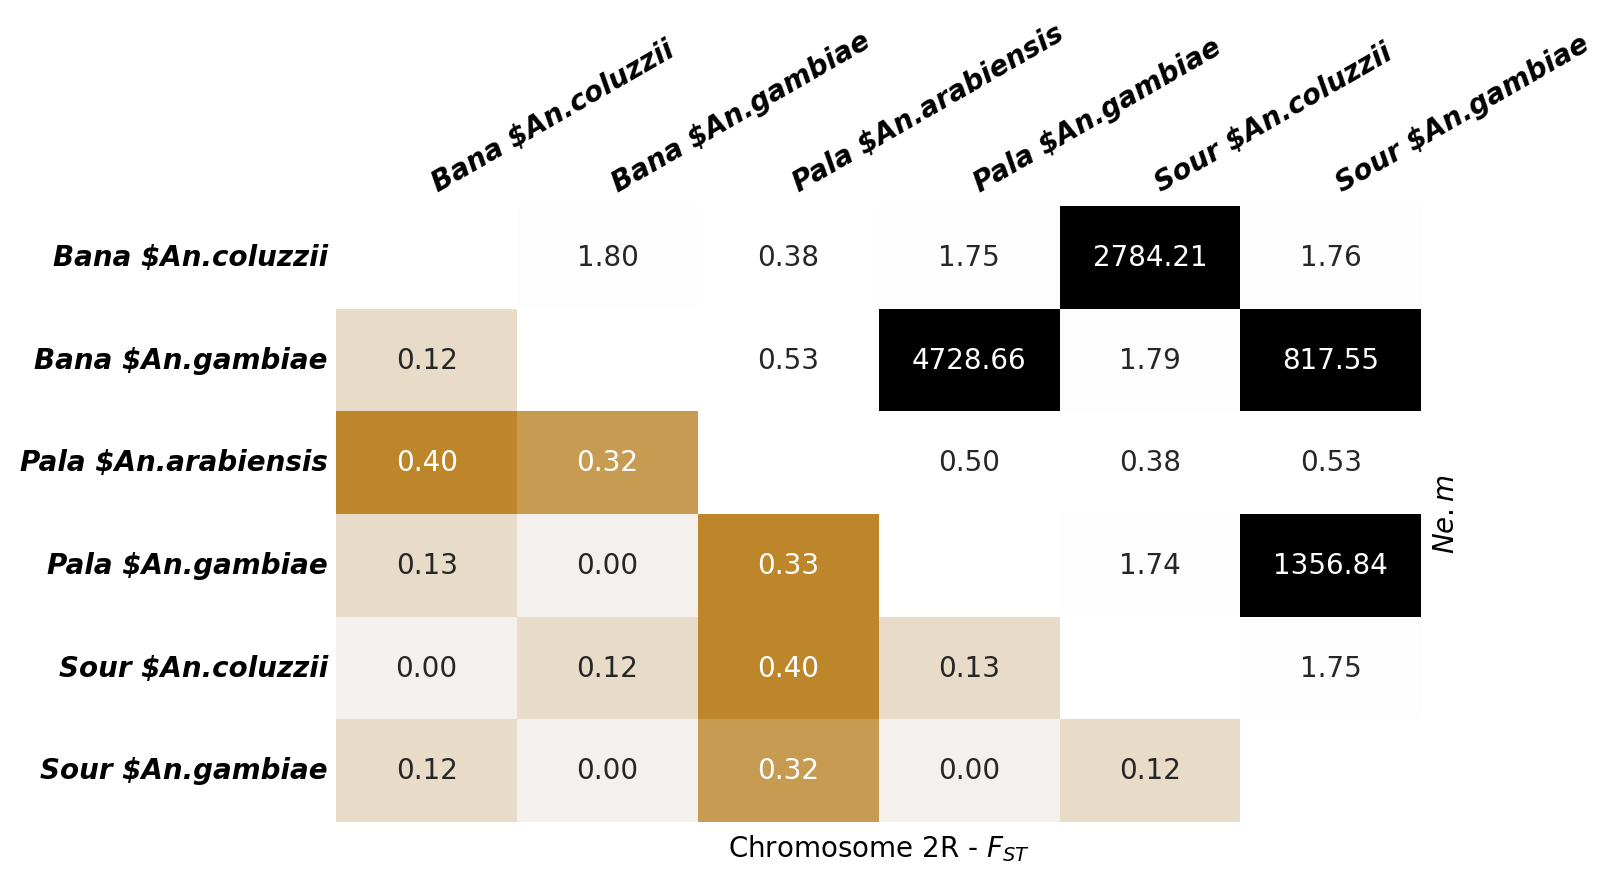

In [48]:
plot_pairwise_fst(fst=fst_2R[0], Nem=Nm(fst_2R[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                  xlabel=True, ylabel=True, chrom='2R', fmt='.2f')

In [25]:
#plot_pairwise_fst(fst=fst_2R[0], se=fst_2R[1], pop_coh=sorted(pop_coh), pop_labels=pop_labels, chrom='2R', fmt='.2f')
#plot_pairwise_fst(fst=fst_2L[0], se=fst_2L[1], pop_coh=sorted(pop_coh), pop_labels=pop_labels, chrom='2L', fmt='.2f')
#plot_pairwise_fst(fst=fst_3R[0], se=fst_3R[1], pop_coh=sorted(pop_coh), pop_labels=pop_labels, chrom='3R', fmt='.2f')
#plot_pairwise_fst(fst=fst_3L[0], se=fst_3L[1], pop_coh=sorted(pop_coh), pop_labels=pop_labels, chrom='3L', fmt='.2f')
#plot_pairwise_fst(fst=fst_X[0], se=fst_X[1], pop_coh=sorted(pop_coh), pop_labels=pop_labels, chrom='X', fmt='.2f', fig_name='X_fst')


In [26]:
## Fst
fig, ax = plt.subplots(figsize=(18,7))
gs = GridSpec(2, 3)

ax0 = plt.subplot(gs[0, 0])
plot_pairwise_fst(fst=fst_2R[0], Nem=Nm(fst_2R[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels,xlabel=True, ylabel=True, ax=ax0, chrom='2R', fmt='.2f')

ax1 = plt.subplot(gs[0, 1])
plot_pairwise_fst(fst=fst_2L[0], Nem=Nm(fst_2L[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels, xlabel=True, ax=ax1, chrom='2L', fmt='.2f')

ax2 = plt.subplot(gs[0, 2])
plot_pairwise_fst(fst=fst_3R[0], Nem=Nm(fst_3R[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels,xlabel=True, ax=ax2, chrom='3R', fmt='.2f')

ax3 = plt.subplot(gs[1, 0])
plot_pairwise_fst(fst=fst_3L[0], Nem=Nm(fst_3L[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels, ylabel=True, ax=ax3, chrom='3L', fmt='.2f')

ax4 = plt.subplot(gs[1, 1])
plot_pairwise_fst(fst=fst_X[0], Nem=Nm(fst_X[0]), pop_coh=sorted(pop_coh), pop_labels=pop_labels, ax=ax4, chrom='X', fmt='.2f')

fig.savefig(f"drive/MyDrive/Genomic/Fst/Whole_Fst_Nem.png", dpi=300, bbox_inches='tight')

<ipython-input-26-41b3a4c042e2>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


<ipython-input-45-cdf9b9e82b88>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


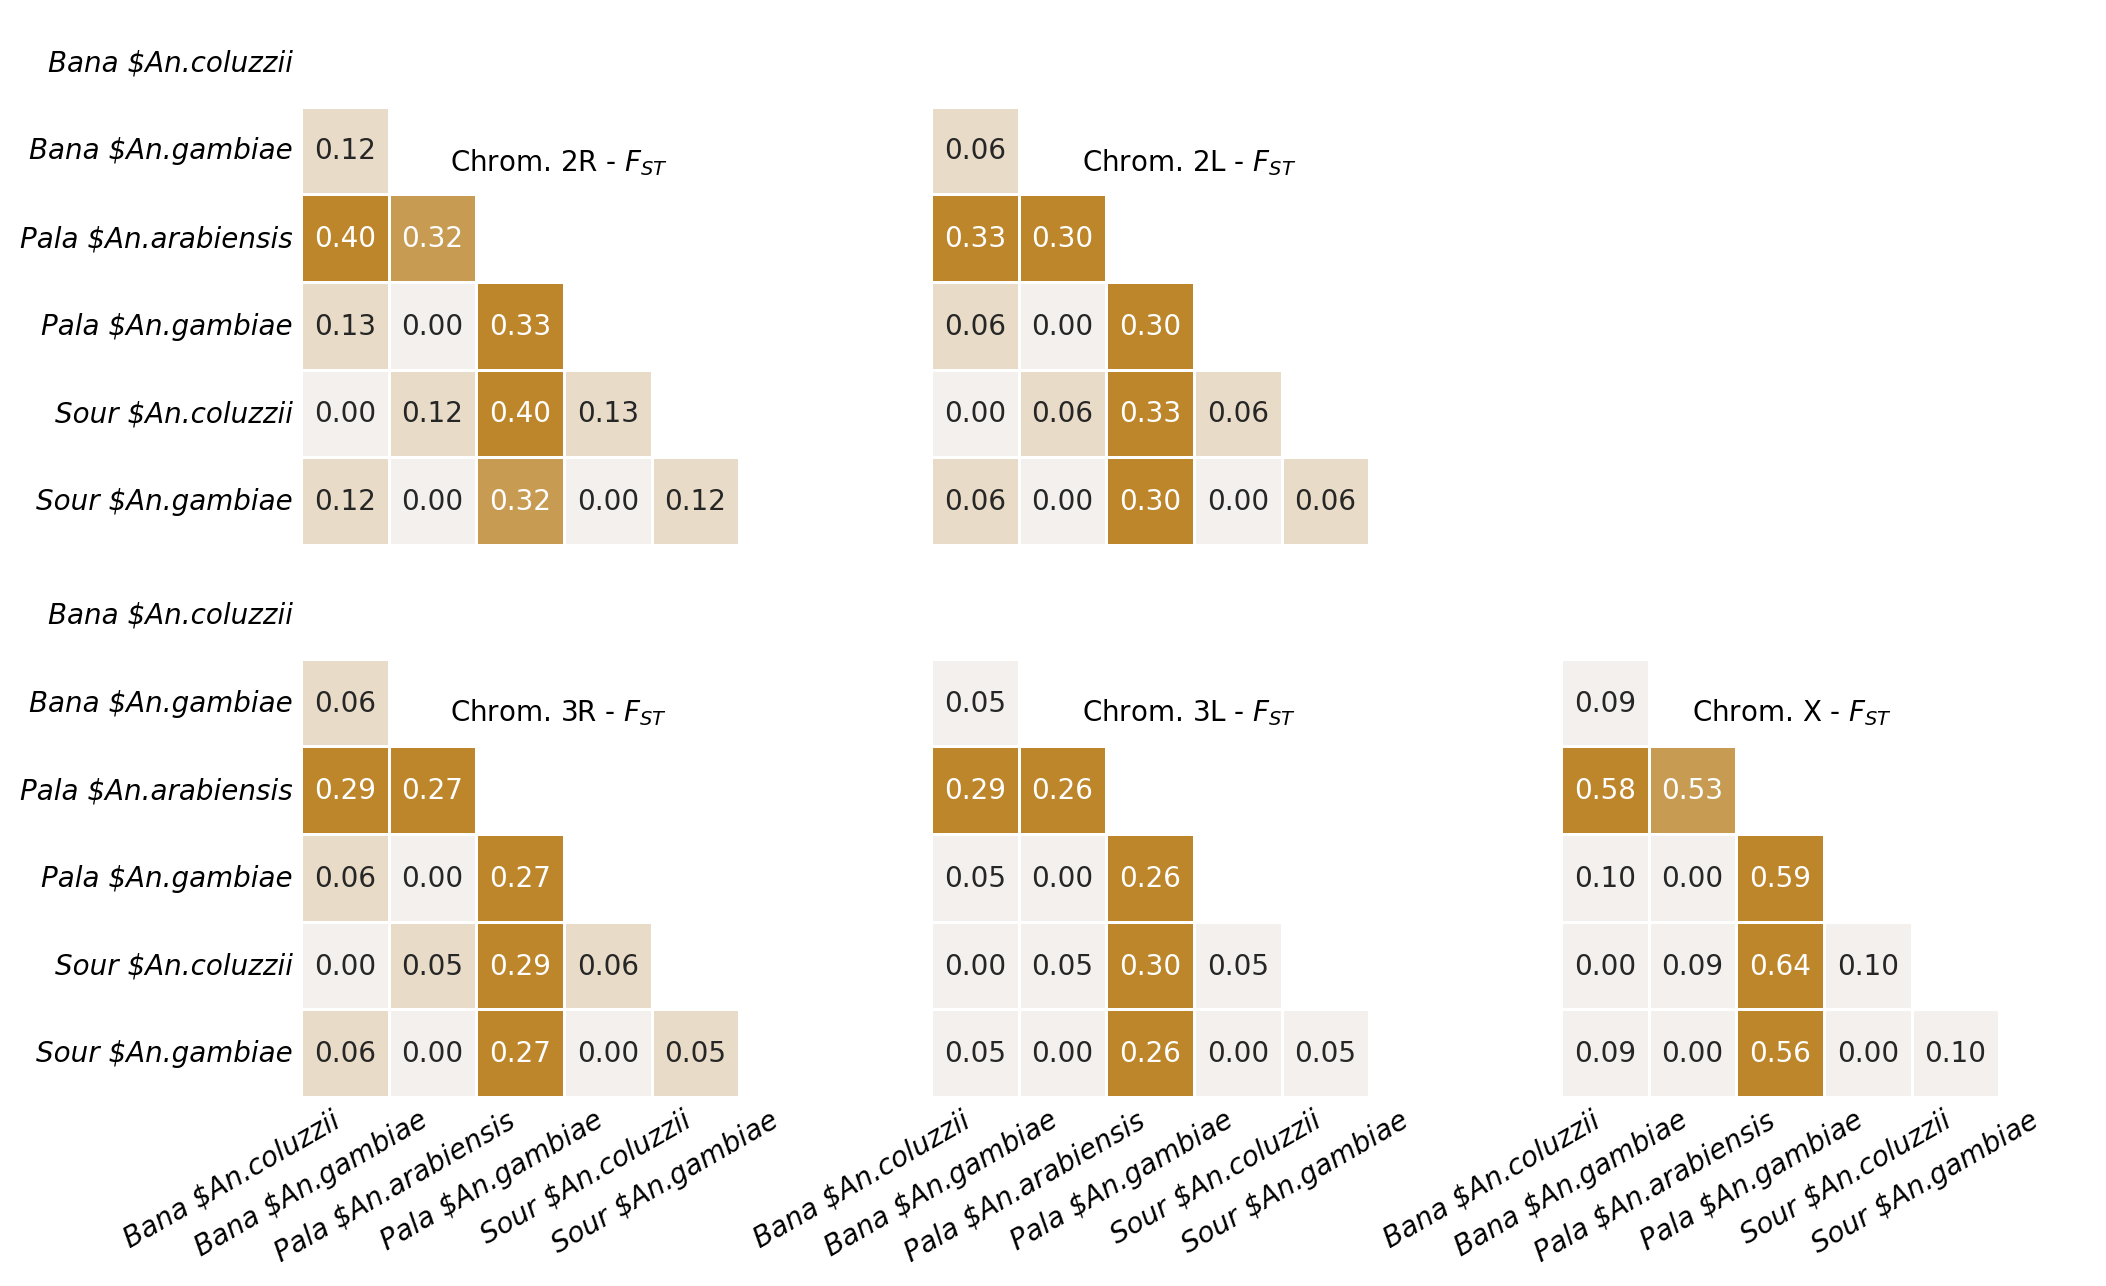

In [45]:
## Fst
fig, ax = plt.subplots(figsize=(12,7))
gs = GridSpec(2, 3, wspace=0.05, hspace=0.05)

ax0 = plt.subplot(gs[0, 0])
plot_pairwise_fst1(fst=fst_2R[0], pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                   xlabel=False, ylabel=True, ax=ax0, chrom='2R', fmt='.2f')
ax0.text(0.1, 0.86, 'Chrom. 2R' + r' - $F_{ST}$', transform=ax.transAxes, size=10)#,
         #bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))

ax1 = plt.subplot(gs[0, 1])
plot_pairwise_fst1(fst=fst_2L[0], pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                   xlabel=False, ylabel=False, ax=ax1, chrom='2L', fmt='.2f')
ax1.text(0.44, 0.86, 'Chrom. 2L'+ r' - $F_{ST}$', transform=ax.transAxes, size=10)

ax2 = plt.subplot(gs[1, 0])
plot_pairwise_fst1(fst=fst_3R[0], pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                   xlabel=True, ylabel=True, ax=ax2, chrom='3R', fmt='.2f')
ax2.text(0.1, 0.35, 'Chrom. 3R'+ r' - $F_{ST}$', transform=ax.transAxes, size=10)

ax3 = plt.subplot(gs[1, 1])
plot_pairwise_fst1(fst=fst_3L[0], pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                   xlabel=True, ylabel=False, ax=ax3, chrom='3L', fmt='.2f')
ax3.text(0.44, 0.35, 'Chrom. 3L'+ r' - $F_{ST}$', transform=ax.transAxes, size=10)

ax4 = plt.subplot(gs[1, 2])
plot_pairwise_fst1(fst=fst_X[0], pop_coh=sorted(pop_coh), pop_labels=pop_labels,
                   xlabel=True, ylabel=False,ax=ax4, chrom='X', fmt='.2f')
ax4.text(0.768, 0.35, 'Chrom. X'+ r' - $F_{ST}$', transform=ax.transAxes, size=10)

fig.savefig(f"drive/MyDrive/Genomic/Fst/Whole_Fst_300px.png", dpi=300, bbox_inches='tight')
fig.savefig(f"drive/MyDrive/Genomic/Fst/Whole_Fst_150px.png", dpi=150, bbox_inches='tight')
fig.savefig(f"drive/MyDrive/Genomic/Fst/Whole_Fst_100px.png", dpi=100, bbox_inches='tight')

In [28]:
plot_pairwise_fst1(fst=fst_2R[0], figsize=(3.5, 3.5), pop_coh=sorted(pop_coh), pop_labels=pop_labels, xlabel=True,
                   ylabel=True, chrom='3L',fs=8, fmt='.2f')

# Year to year Fst

In [29]:
# Import data
ag_fst_2R = load_fst_np(file='2R_yty_fst_gambiae.npy')
ac_fst_2R = load_fst_np(file='2R_yty_fst_coluzzii.npy')
aa_fst_2R = load_fst_np(file='2R_yty_fst_arabiensis.npy')

ag_fst_2L = load_fst_np(file='2L_yty_fst_gambiae.npy')
ac_fst_2L = load_fst_np(file='2L_yty_fst_coluzzii.npy')
aa_fst_2L = load_fst_np(file='2L_yty_fst_arab.npy')

ag_fst_3R = load_fst_np(file='3R_yty_fst_gambiae.npy')
ac_fst_3R = load_fst_np(file='3R_yty_fst_coluzzii.npy')
aa_fst_3R = load_fst_np(file='3R_yty_fst_arabiensis.npy')

ag_fst_3L = load_fst_np(file='3L_yty_fst_gambiae.npy')
ac_fst_3L = load_fst_np(file='3L_yty_fst_coluzzii.npy')
aa_fst_3L = load_fst_np(file='3L_yty_fst_arab.npy')

ag_fst_X = load_fst_np(file='X_yty_fst_gambiae.npy')
ac_fst_X = load_fst_np(file='X_yty_fst_coluzzii.npy')
aa_fst_X = load_fst_np(file='X_yty_fst_arabiensis.npy')

In [ ]:
fst_stat_2R

<ipython-input-53-58269dc623ef>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
<ipython-input-49-7b6a5eda0fba>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


Text(48092262, 0.07, '$dsx$')

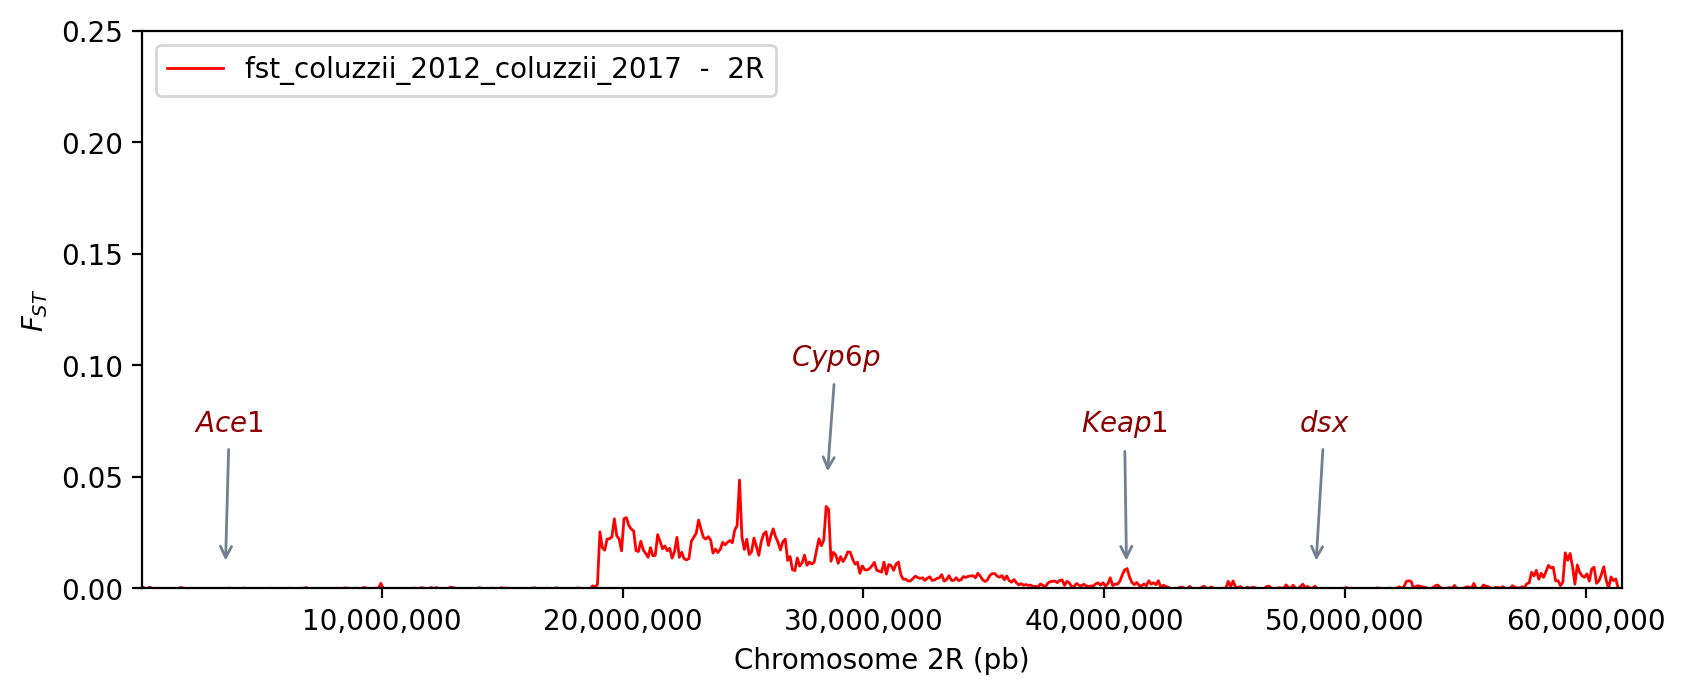

In [53]:
fig, ax = plt.subplots(figsize=(21,21))
gs = GridSpec(5, 2)

ax0 = plt.subplot(gs[0, 0])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax0, xlab='2R', color='red', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(3497400, 0.01), xytext=(2207400, 0.07), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'))
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(28493314, 0.05), xytext=(27001242, 0.10), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'))
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(40926764, 0.01), xytext=(39036764, 0.07), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'))
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$dsx$', xy=(48792262, 0.01), xytext=(48092262, 0.07), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'))

In [31]:
#fst_stat_3L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"')

<ipython-input-51-1b42086bb48a>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1, 0])
<ipython-input-49-7b6a5eda0fba>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


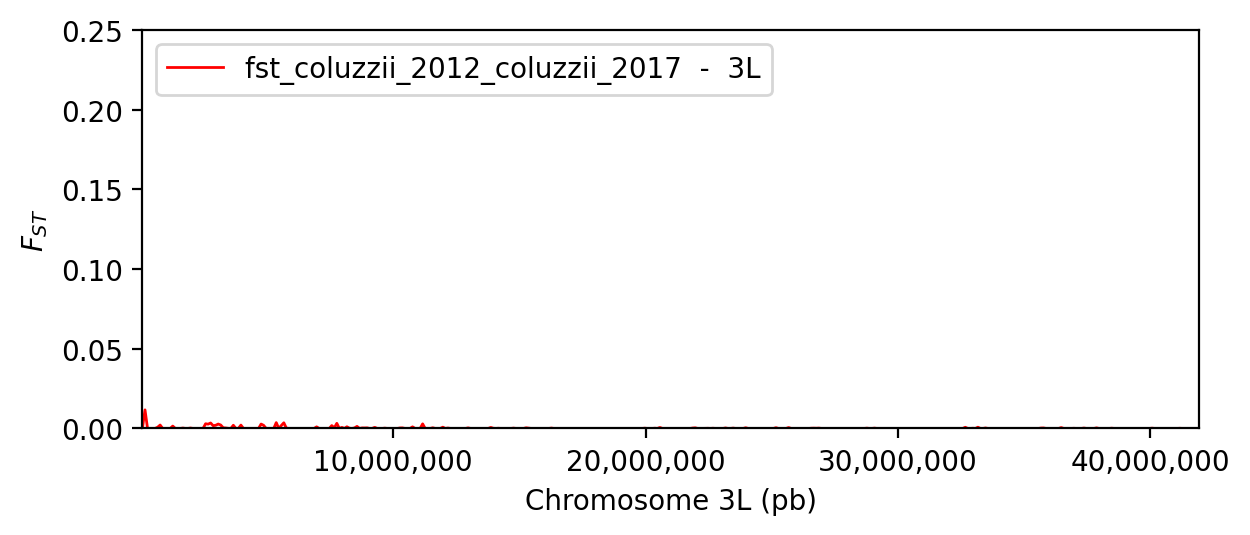

In [51]:
fig, ax = plt.subplots(figsize=(15,15))
gs = GridSpec(5, 2)

ax2 = plt.subplot(gs[1, 0])
ax2.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax2, xlab='3L', color='red', ylab=True, lab="fst_coluzzii_2012_coluzzii_2017")

<ipython-input-74-7f5d4dbf962e>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1, 0])
<ipython-input-72-54dc90eaceb9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


Text(25003652, 0.06, '$rdl$ ')

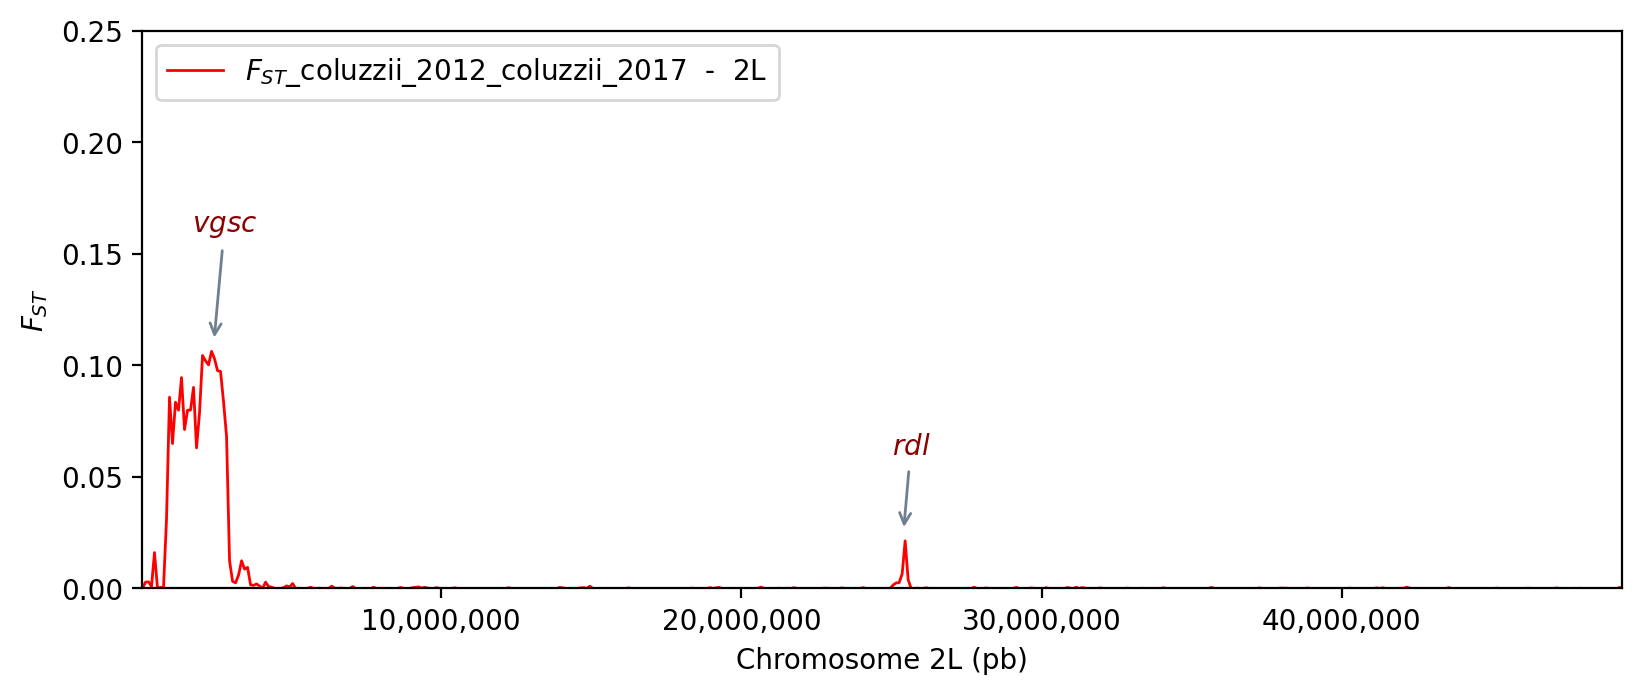

In [74]:
fig, ax = plt.subplots(figsize=(21,21))
gs = GridSpec(5, 2)

ax2 = plt.subplot(gs[1, 0])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax2, xlab='2L', color='red', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(2431617, 0.11), xytext=(1700008, 0.16),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))

#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.025), xytext=(25003652, 0.06),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'))

<ipython-input-75-9e6144a35723>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax8 = plt.subplot(gs[4, 0])
<ipython-input-72-54dc90eaceb9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


Text(15241718.0, 0.09, '$Cyp9k1$')

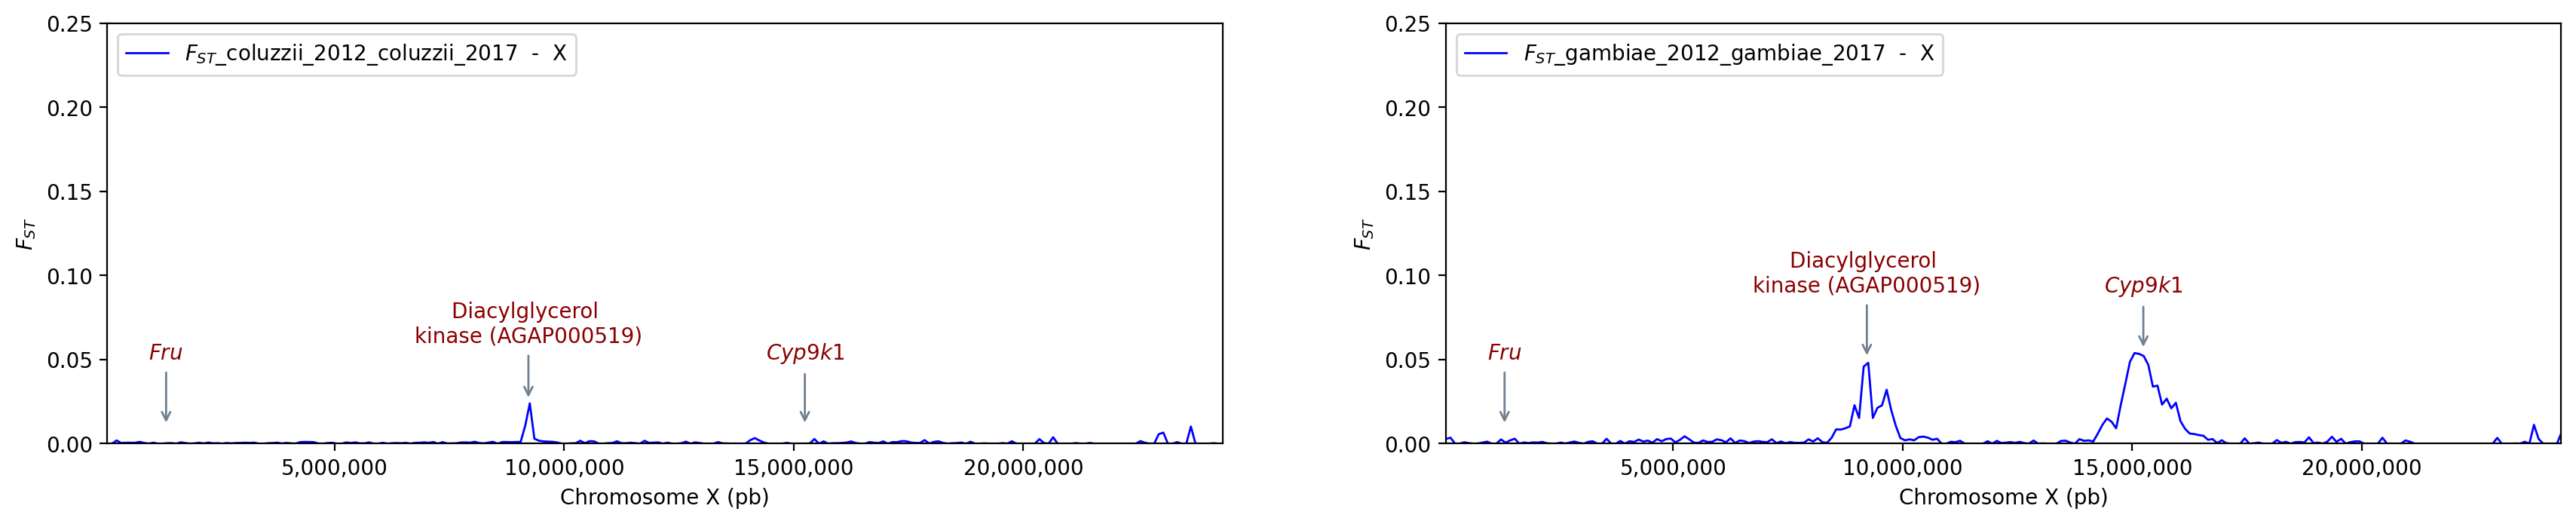

In [75]:
fig, ax = plt.subplots(figsize=(21,21))
gs = GridSpec(5, 2)
ax8 = plt.subplot(gs[4, 0])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax8, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Fru$ ', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.025), xytext=(np.mean([9200001,9240000]), 0.06), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.01), xytext=(np.mean([15240572, 15242864]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax9 = plt.subplot(gs[4, 1])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax9, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Fru$', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.05), xytext=(np.mean([9200001,9240000]), 0.09), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.055), xytext=(np.mean([15240572, 15242864]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')


<ipython-input-81-43d87b1c37ba>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
<ipython-input-72-54dc90eaceb9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


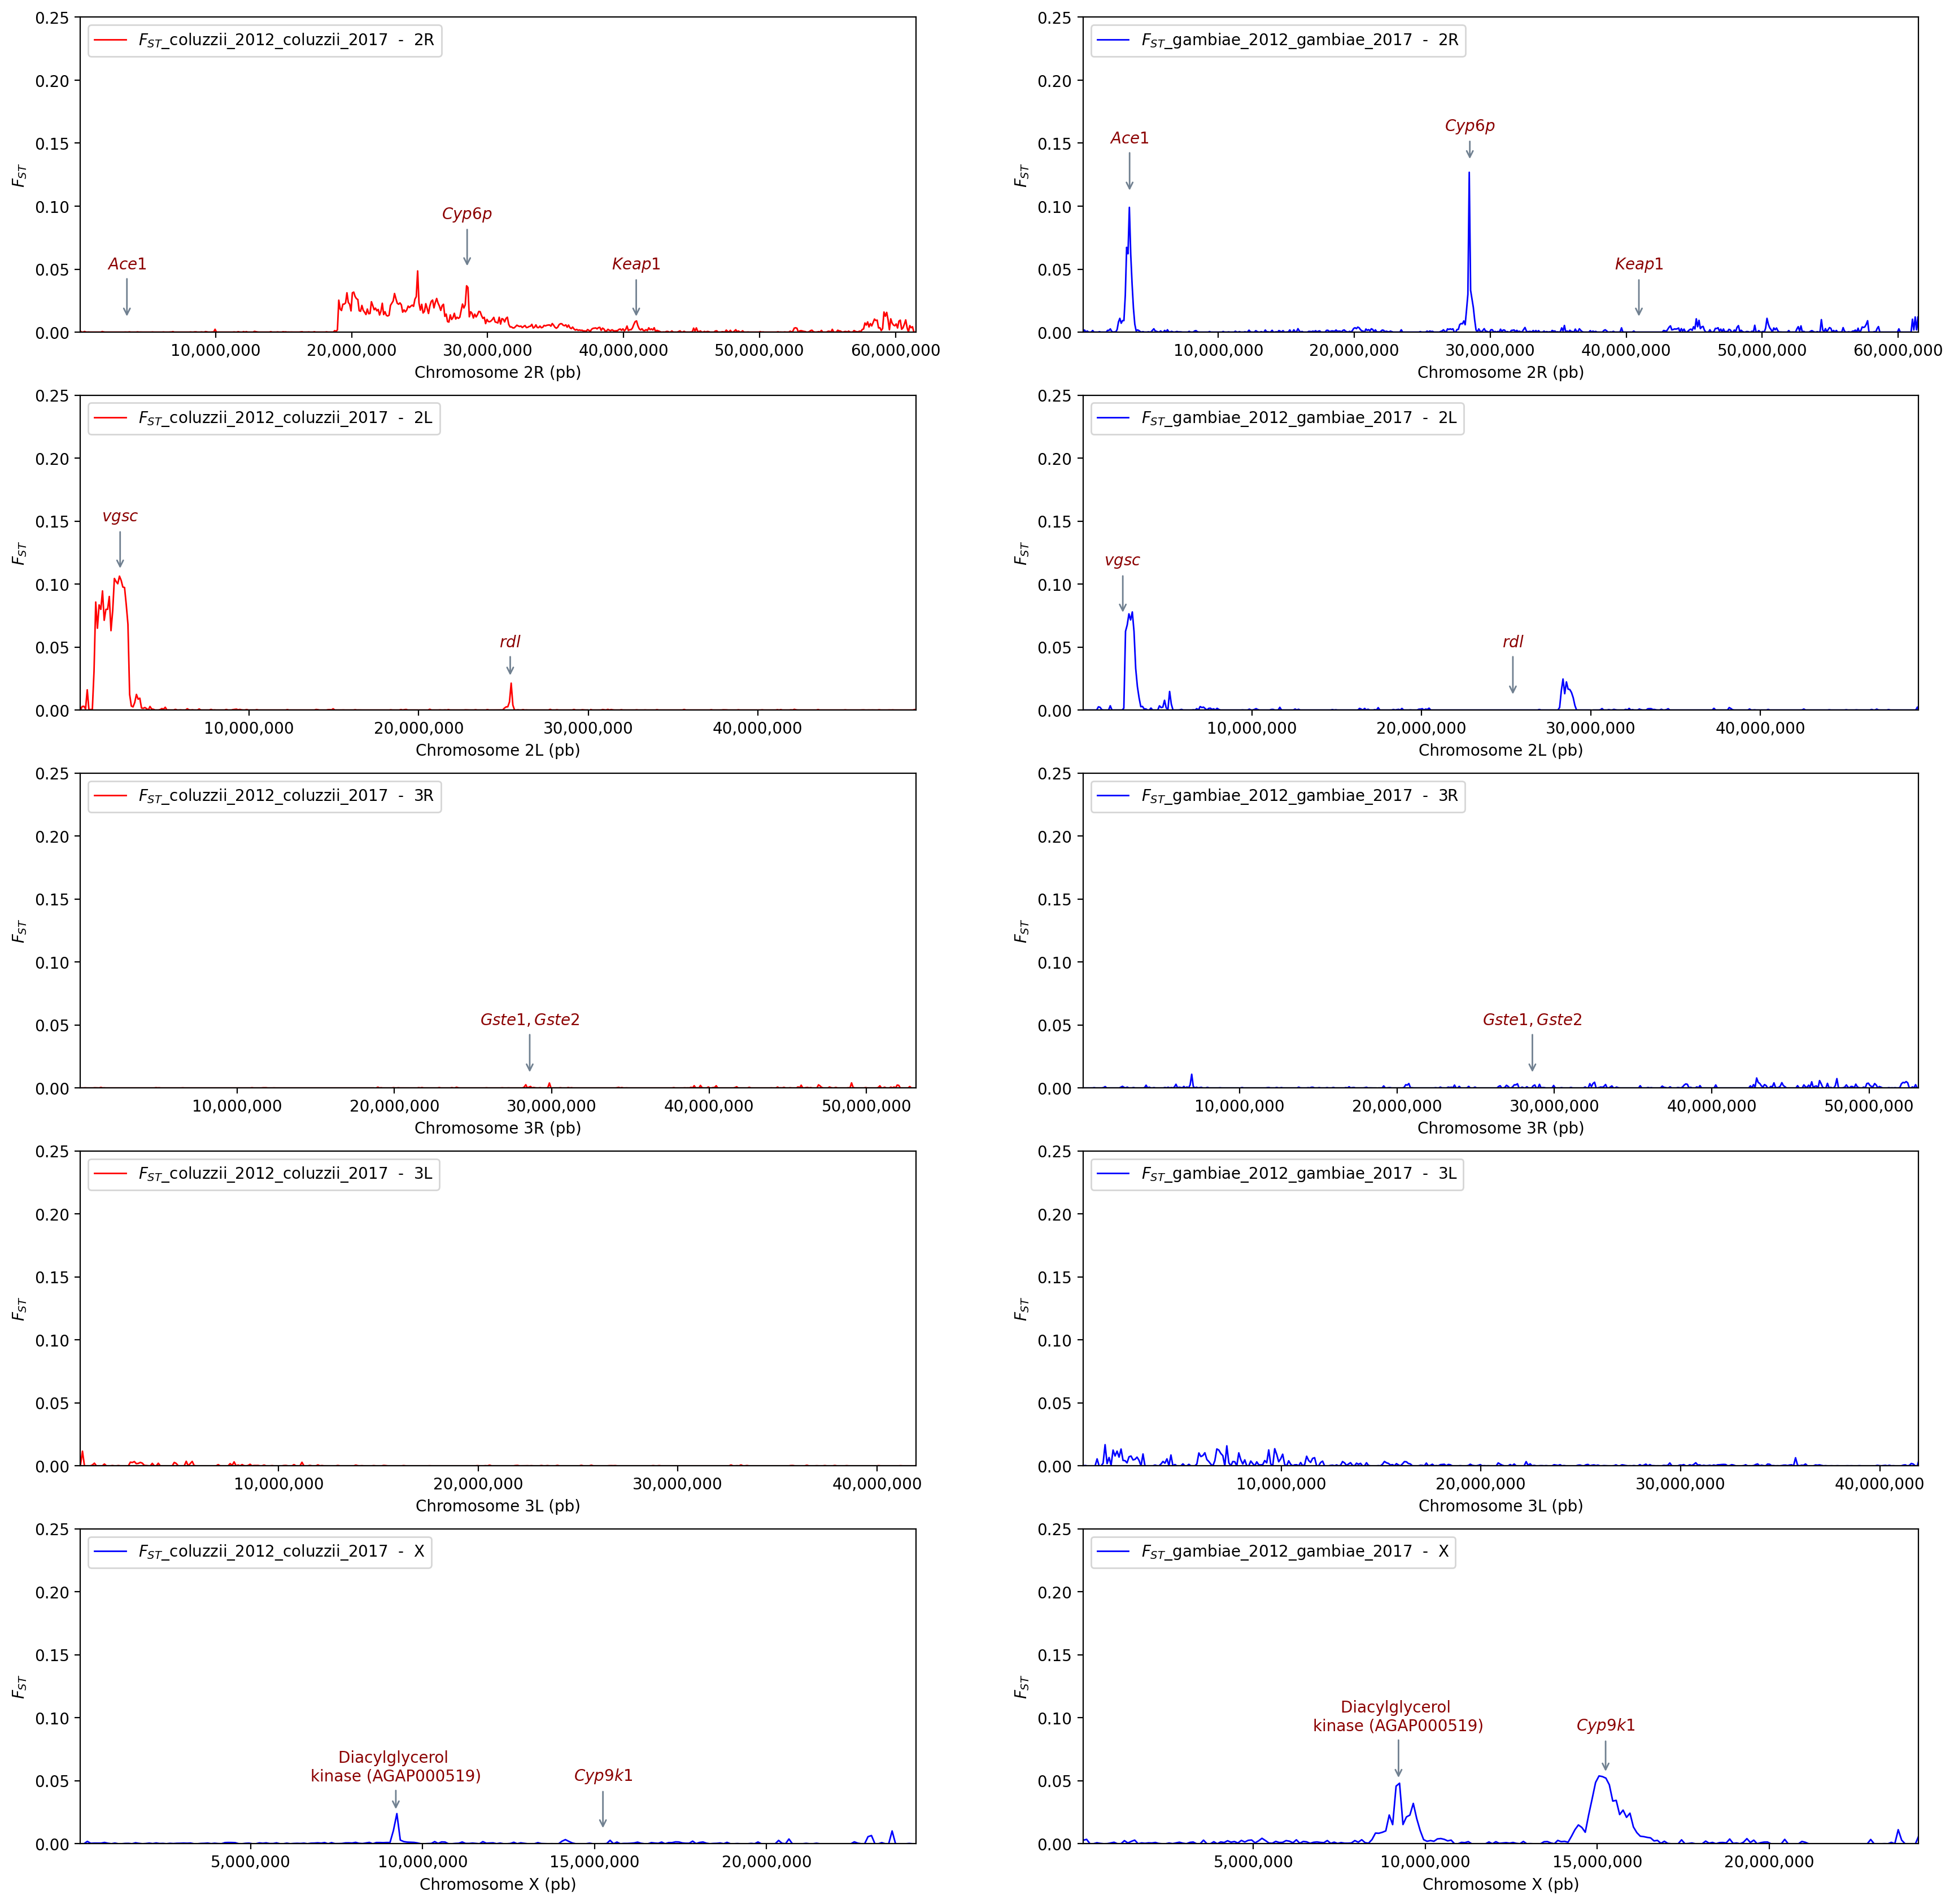

In [81]:
fig, ax = plt.subplots(figsize=(21,21))
gs = GridSpec(5, 2)

ax0 = plt.subplot(gs[0, 0])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax0, xlab='2R', color='red', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(np.mean([3438301, 3497400]), 0.01), xytext=(np.mean([3438301, 3497400]), 0.05), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(np.mean([28491242, 28493314]), 0.05), xytext=(np.mean([28491242, 28493314]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(np.mean([40926764 , 40930610]), 0.01), xytext=(np.mean([40926764 , 40930610]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
#plt.annotate('$Dsx$', xy=(np.mean([48703664, 48792262]), 0.01), xytext=(np.mean([48703664, 48792262]), 0.05), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[0, 1])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax1, xlab='2R', color='blue', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(np.mean([3438301, 3497400]), 0.11), xytext=(np.mean([3438301, 3497400]), 0.15), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(np.mean([28491242, 28493314]), 0.135), xytext=(np.mean([28491242, 28493314]), 0.16), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(np.mean([40926764 , 40930610]), 0.01), xytext=(np.mean([40926764 , 40930610]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
#plt.annotate('$Dsx$', xy=(np.mean([48703664, 48792262]), 0.01), xytext=(np.mean([48703664, 48792262]), 0.05), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax2 = plt.subplot(gs[1, 0])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax2, xlab='2L', color='red', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(np.mean([2358158, 2431617]), 0.11), xytext=(np.mean([2358158, 2431617]), 0.15),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.025), xytext=(np.mean([25363652, 25434556]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax3 = plt.subplot(gs[1, 1])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax3, xlab='2L', color='blue', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(np.mean([2358158, 2431617]), 0.075), xytext=(np.mean([2358158, 2431617]), 0.115),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.01), xytext=(np.mean([25363652, 25434556]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax4 = plt.subplot(gs[2, 0])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax4, xlab='3R', color='red', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax5 = plt.subplot(gs[2, 1])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax5, xlab='3R', color='blue', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax6 = plt.subplot(gs[3, 0])
ax6.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax6, xlab='3L', color='red', ylab=True)

ax7 = plt.subplot(gs[3, 1])
ax7.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax7, xlab='3L', color='blue', ylab=True)

ax8 = plt.subplot(gs[4, 0])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax8, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
#plt.annotate('$Fru$ ', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
#             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.025), xytext=(np.mean([9200001,9240000]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.01), xytext=(np.mean([15240572, 15242864]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax9 = plt.subplot(gs[4, 1])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax9, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
#plt.annotate('$Fru$', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
#             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.05), xytext=(np.mean([9200001,9240000]), 0.09), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.055), xytext=(np.mean([15240572, 15242864]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

fig.savefig(f"drive/MyDrive/Genomic/Fst/yty_Whole_Fst.png", dpi=300, bbox_inches='tight')

In [ ]:
## Fst - An. gambiae ss
fig, ax = plt.subplots(figsize=(18,6))
gs = GridSpec(2, 3)
gamb = ['gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']


ax0 = plt.subplot(gs[0, 0])
plot_pairwise_fst(fst=ag_fst_2R[0], se=ag_fst_2R[1], pop_coh=gamb, pop_labels=sp_labels, xlabel=True, ylabel=True, ax=ax0, chrom='2R')

ax1 = plt.subplot(gs[0, 1])
plot_pairwise_fst(fst=ag_fst_2L[0], se=ag_fst_2L[1], pop_coh=gamb, pop_labels=sp_labels, xlabel=True, ax=ax1,  chrom='2L')

ax2 = plt.subplot(gs[0, 2])
plot_pairwise_fst(fst=ag_fst_3R[0], se=ag_fst_3R[1], pop_coh=gamb, pop_labels=sp_labels, xlabel=True, ax=ax2,  chrom='3R')

ax3 = plt.subplot(gs[1, 0])
plot_pairwise_fst(fst=ag_fst_3L[0], se=ag_fst_3L[1], pop_coh=gamb, pop_labels=sp_labels, ylabel=True, ax=ax3, chrom='3L')

ax4 = plt.subplot(gs[1, 1])
plot_pairwise_fst(fst=ag_fst_X[0], se=ag_fst_X[1], pop_coh=gamb, pop_labels=sp_labels, ax=ax4,  chrom='X')

fig.savefig(f"drive/MyDrive/Genomic/Fst/yty_Whole_Fst_gambiae.png", dpi=300, bbox_inches='tight')

In [ ]:
## Fst - An. coluzzii
fig, ax = plt.subplots(figsize=(18,6))
gs = GridSpec(2, 3)
coluzzii = ['coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017']

ax0 = plt.subplot(gs[0, 0])
plot_pairwise_fst(fst=ac_fst_2R[0], se=ac_fst_2R[1], pop_coh=coluzzii, pop_labels=sp_labels, xlabel=True, ylabel=True, ax=ax0, chrom='2R')

ax1 = plt.subplot(gs[0, 1])
plot_pairwise_fst(fst=ac_fst_2L[0], se=ac_fst_2L[1], pop_coh=coluzzii, pop_labels=sp_labels, xlabel=True, ax=ax1,  chrom='2L')

ax2 = plt.subplot(gs[0, 2])
plot_pairwise_fst(fst=ac_fst_3R[0], se=ac_fst_3R[1], pop_coh=coluzzii, pop_labels=sp_labels, xlabel=True, ax=ax2,  chrom='3R')

ax3 = plt.subplot(gs[1, 0])
plot_pairwise_fst(fst=ac_fst_3L[0], se=ac_fst_3L[1], pop_coh=coluzzii, pop_labels=sp_labels, ylabel=True, ax=ax3, chrom='3L')

ax4 = plt.subplot(gs[1, 1])
plot_pairwise_fst(fst=ac_fst_X[0], se=ac_fst_X[1], pop_coh=coluzzii, pop_labels=sp_labels, ax=ax4,  chrom='X')

fig.savefig(f"drive/MyDrive/Genomic/Fst/yty_Whole_Fst_coluzzii.png", dpi=300, bbox_inches='tight')

In [ ]:
## Fst - An. coluzzii
fig, ax = plt.subplots(figsize=(18,6))
gs = GridSpec(2, 3)
arabiensis = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016']

ax0 = plt.subplot(gs[0, 0])
plot_pairwise_fst(fst=aa_fst_2R[0], se=aa_fst_2R[1], pop_coh=arabiensis, pop_labels=sp_labels, xlabel=True, ylabel=True, ax=ax0, chrom='2R')

ax1 = plt.subplot(gs[0, 1])
plot_pairwise_fst(fst=aa_fst_2L[0], se=aa_fst_2L[1], pop_coh=arabiensis, pop_labels=sp_labels, xlabel=True, ax=ax1,  chrom='2L')

ax2 = plt.subplot(gs[0, 2])
plot_pairwise_fst(fst=aa_fst_3R[0], se=aa_fst_3R[1], pop_coh=arabiensis, pop_labels=sp_labels, xlabel=True, ax=ax2,  chrom='3R')

ax3 = plt.subplot(gs[1, 0])
plot_pairwise_fst(fst=aa_fst_3L[0], se=aa_fst_3L[1], pop_coh=arabiensis, pop_labels=sp_labels, ylabel=True, ax=ax3, chrom='3L')

#ax4 = plt.subplot(gs[1, 1])
#plot_pairwise_fst(fst=aa_fst_X[0], se=aa_fst_X[1], pop_coh=arabiensis, pop_labels=sp_labels, ax=ax4,  chrom='X')

fig.savefig(f"drive/MyDrive/Genomic/Fst/yty_Whole_Fst_arabiensis.png", dpi=300, bbox_inches='tight')

<ipython-input-77-3b3e1ae26853>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
<ipython-input-72-54dc90eaceb9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


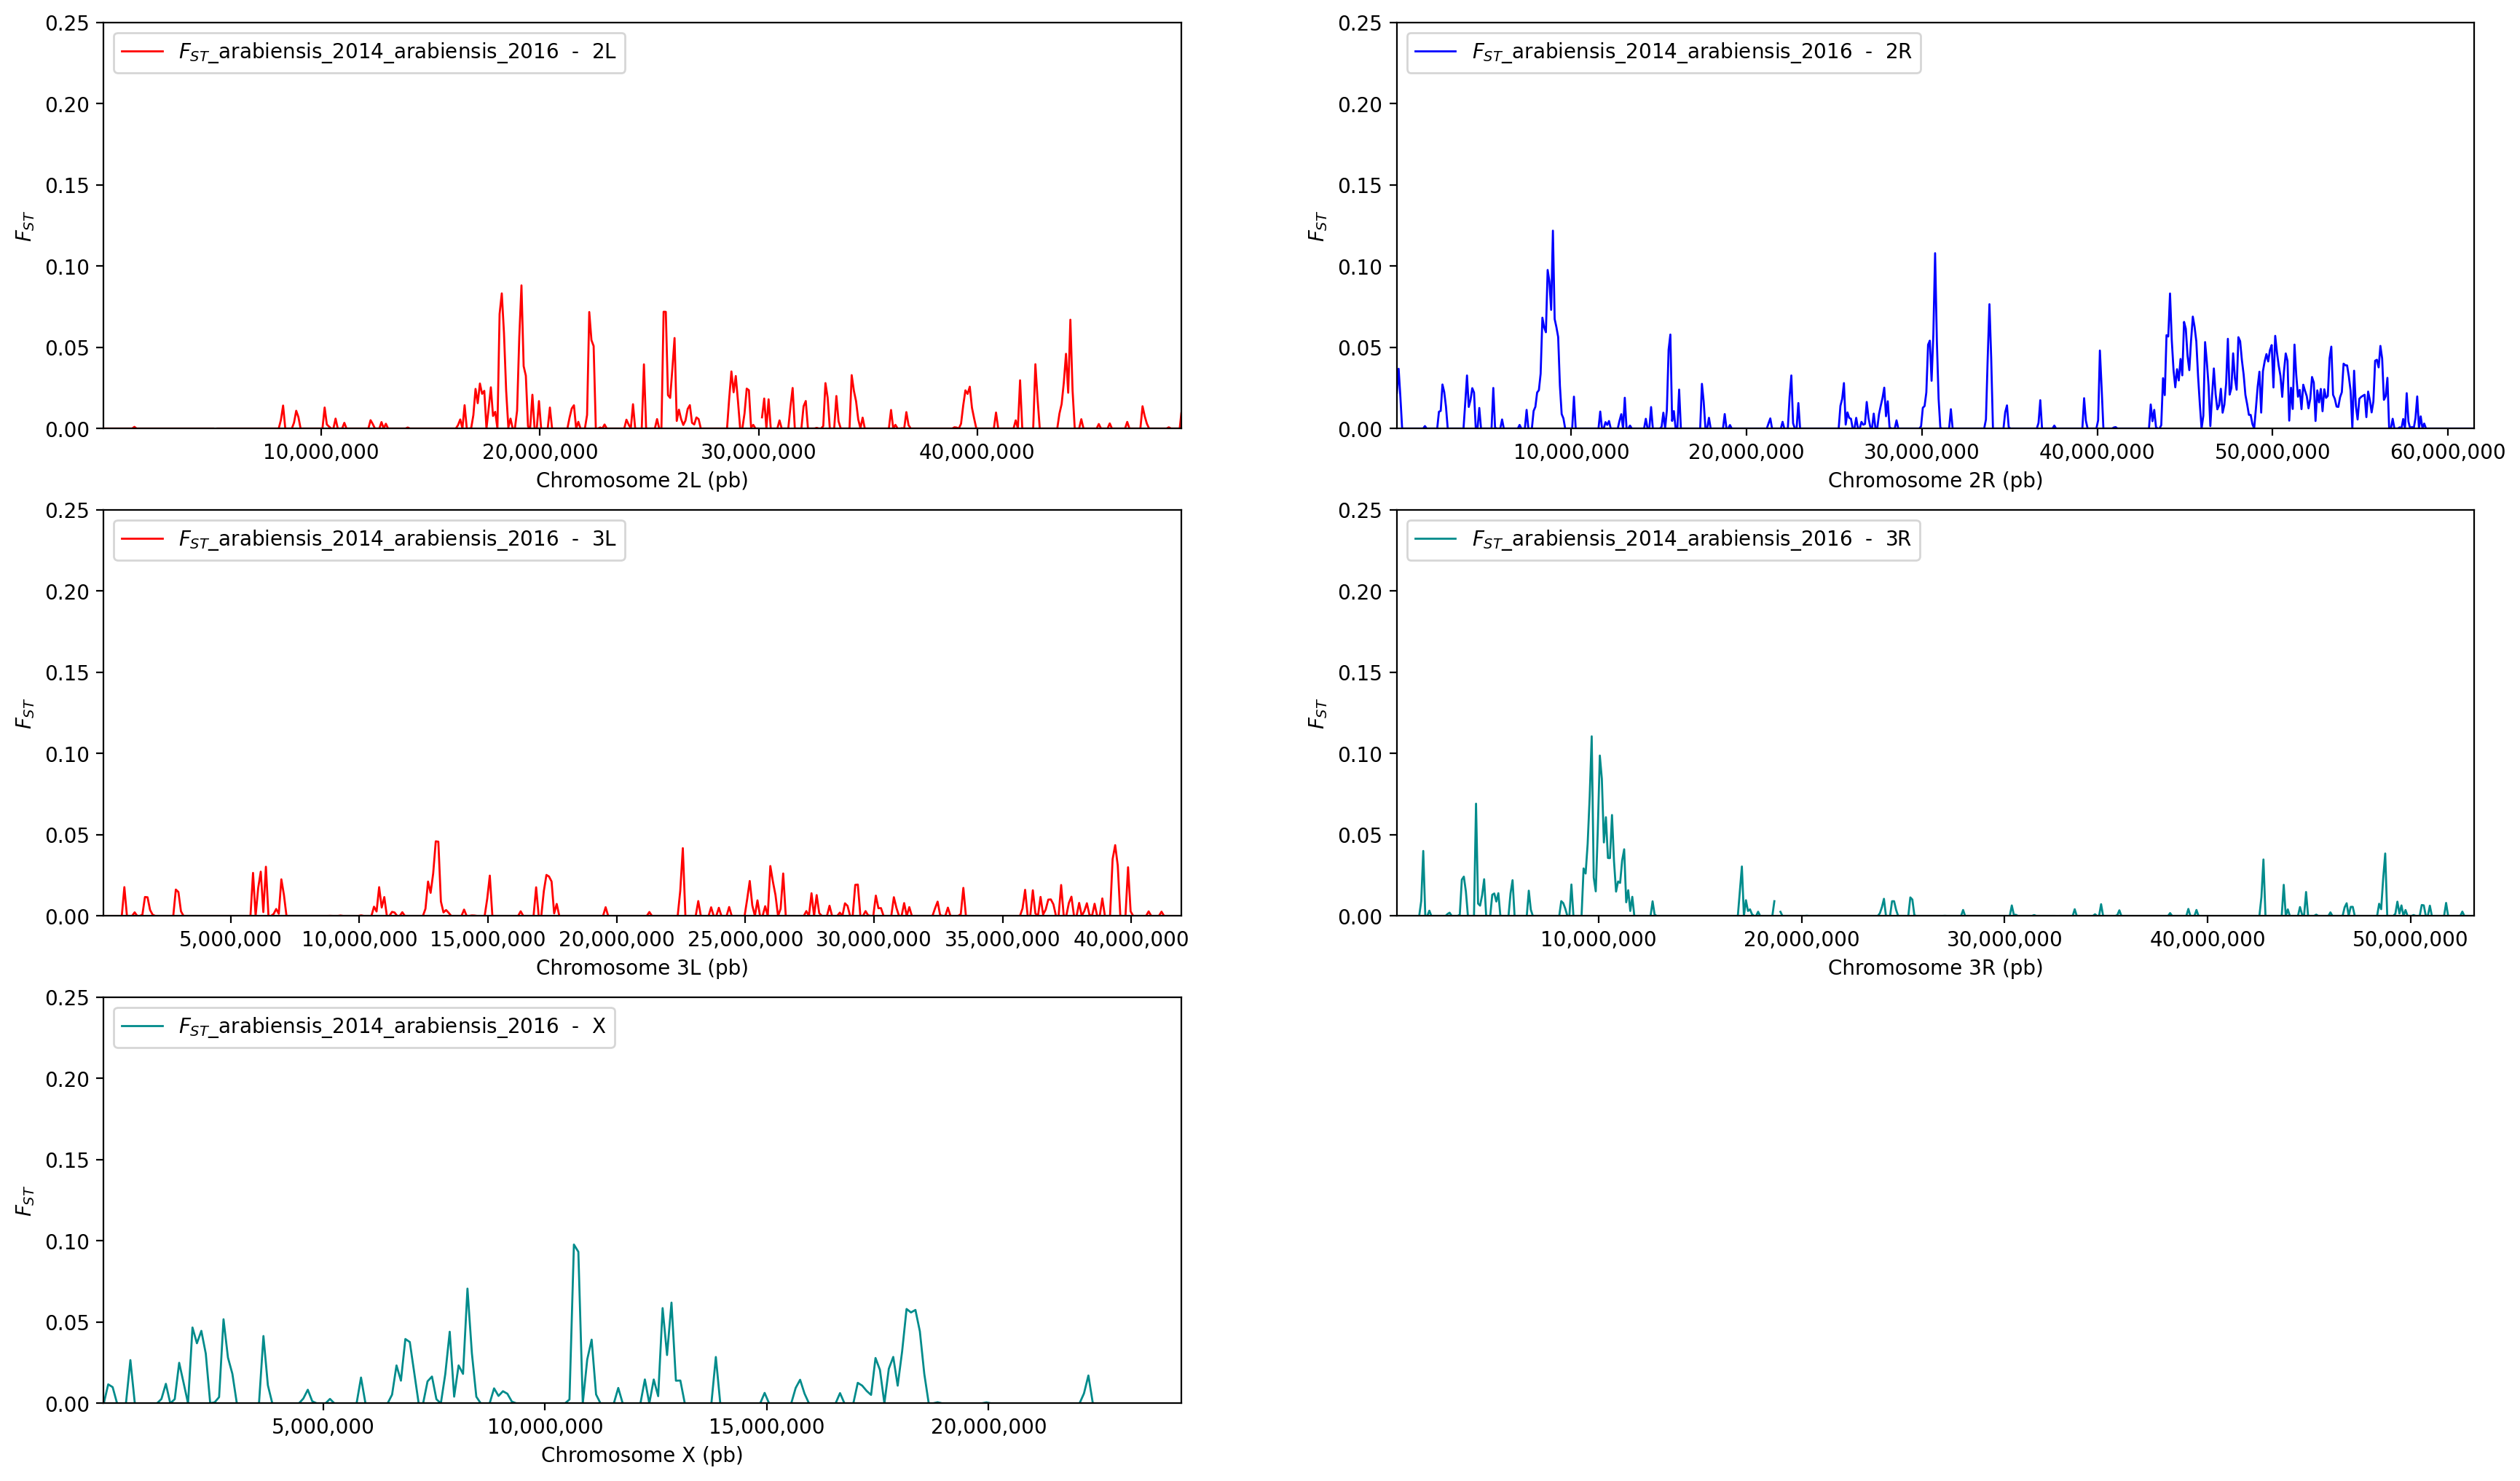

In [77]:
fig, ax = plt.subplots(figsize=(21,21))
gs = GridSpec(5, 2)

ax0 = plt.subplot(gs[0, 0])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax0, xlab='2L', color='red', ylab=True)

ax1 = plt.subplot(gs[0, 1])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax1, xlab='2R', color='blue', ylab=True)

ax2 = plt.subplot(gs[1, 0])
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax2, xlab='3L', color='red', ylab=True)

ax3 = plt.subplot(gs[1, 1])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax3, xlab='3R', color='darkcyan', ylab=True)

ax4 = plt.subplot(gs[2, 0])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax4, xlab='X', color='darkcyan', ylab=True)


<ipython-input-78-193f20790638>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])
<ipython-input-72-54dc90eaceb9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


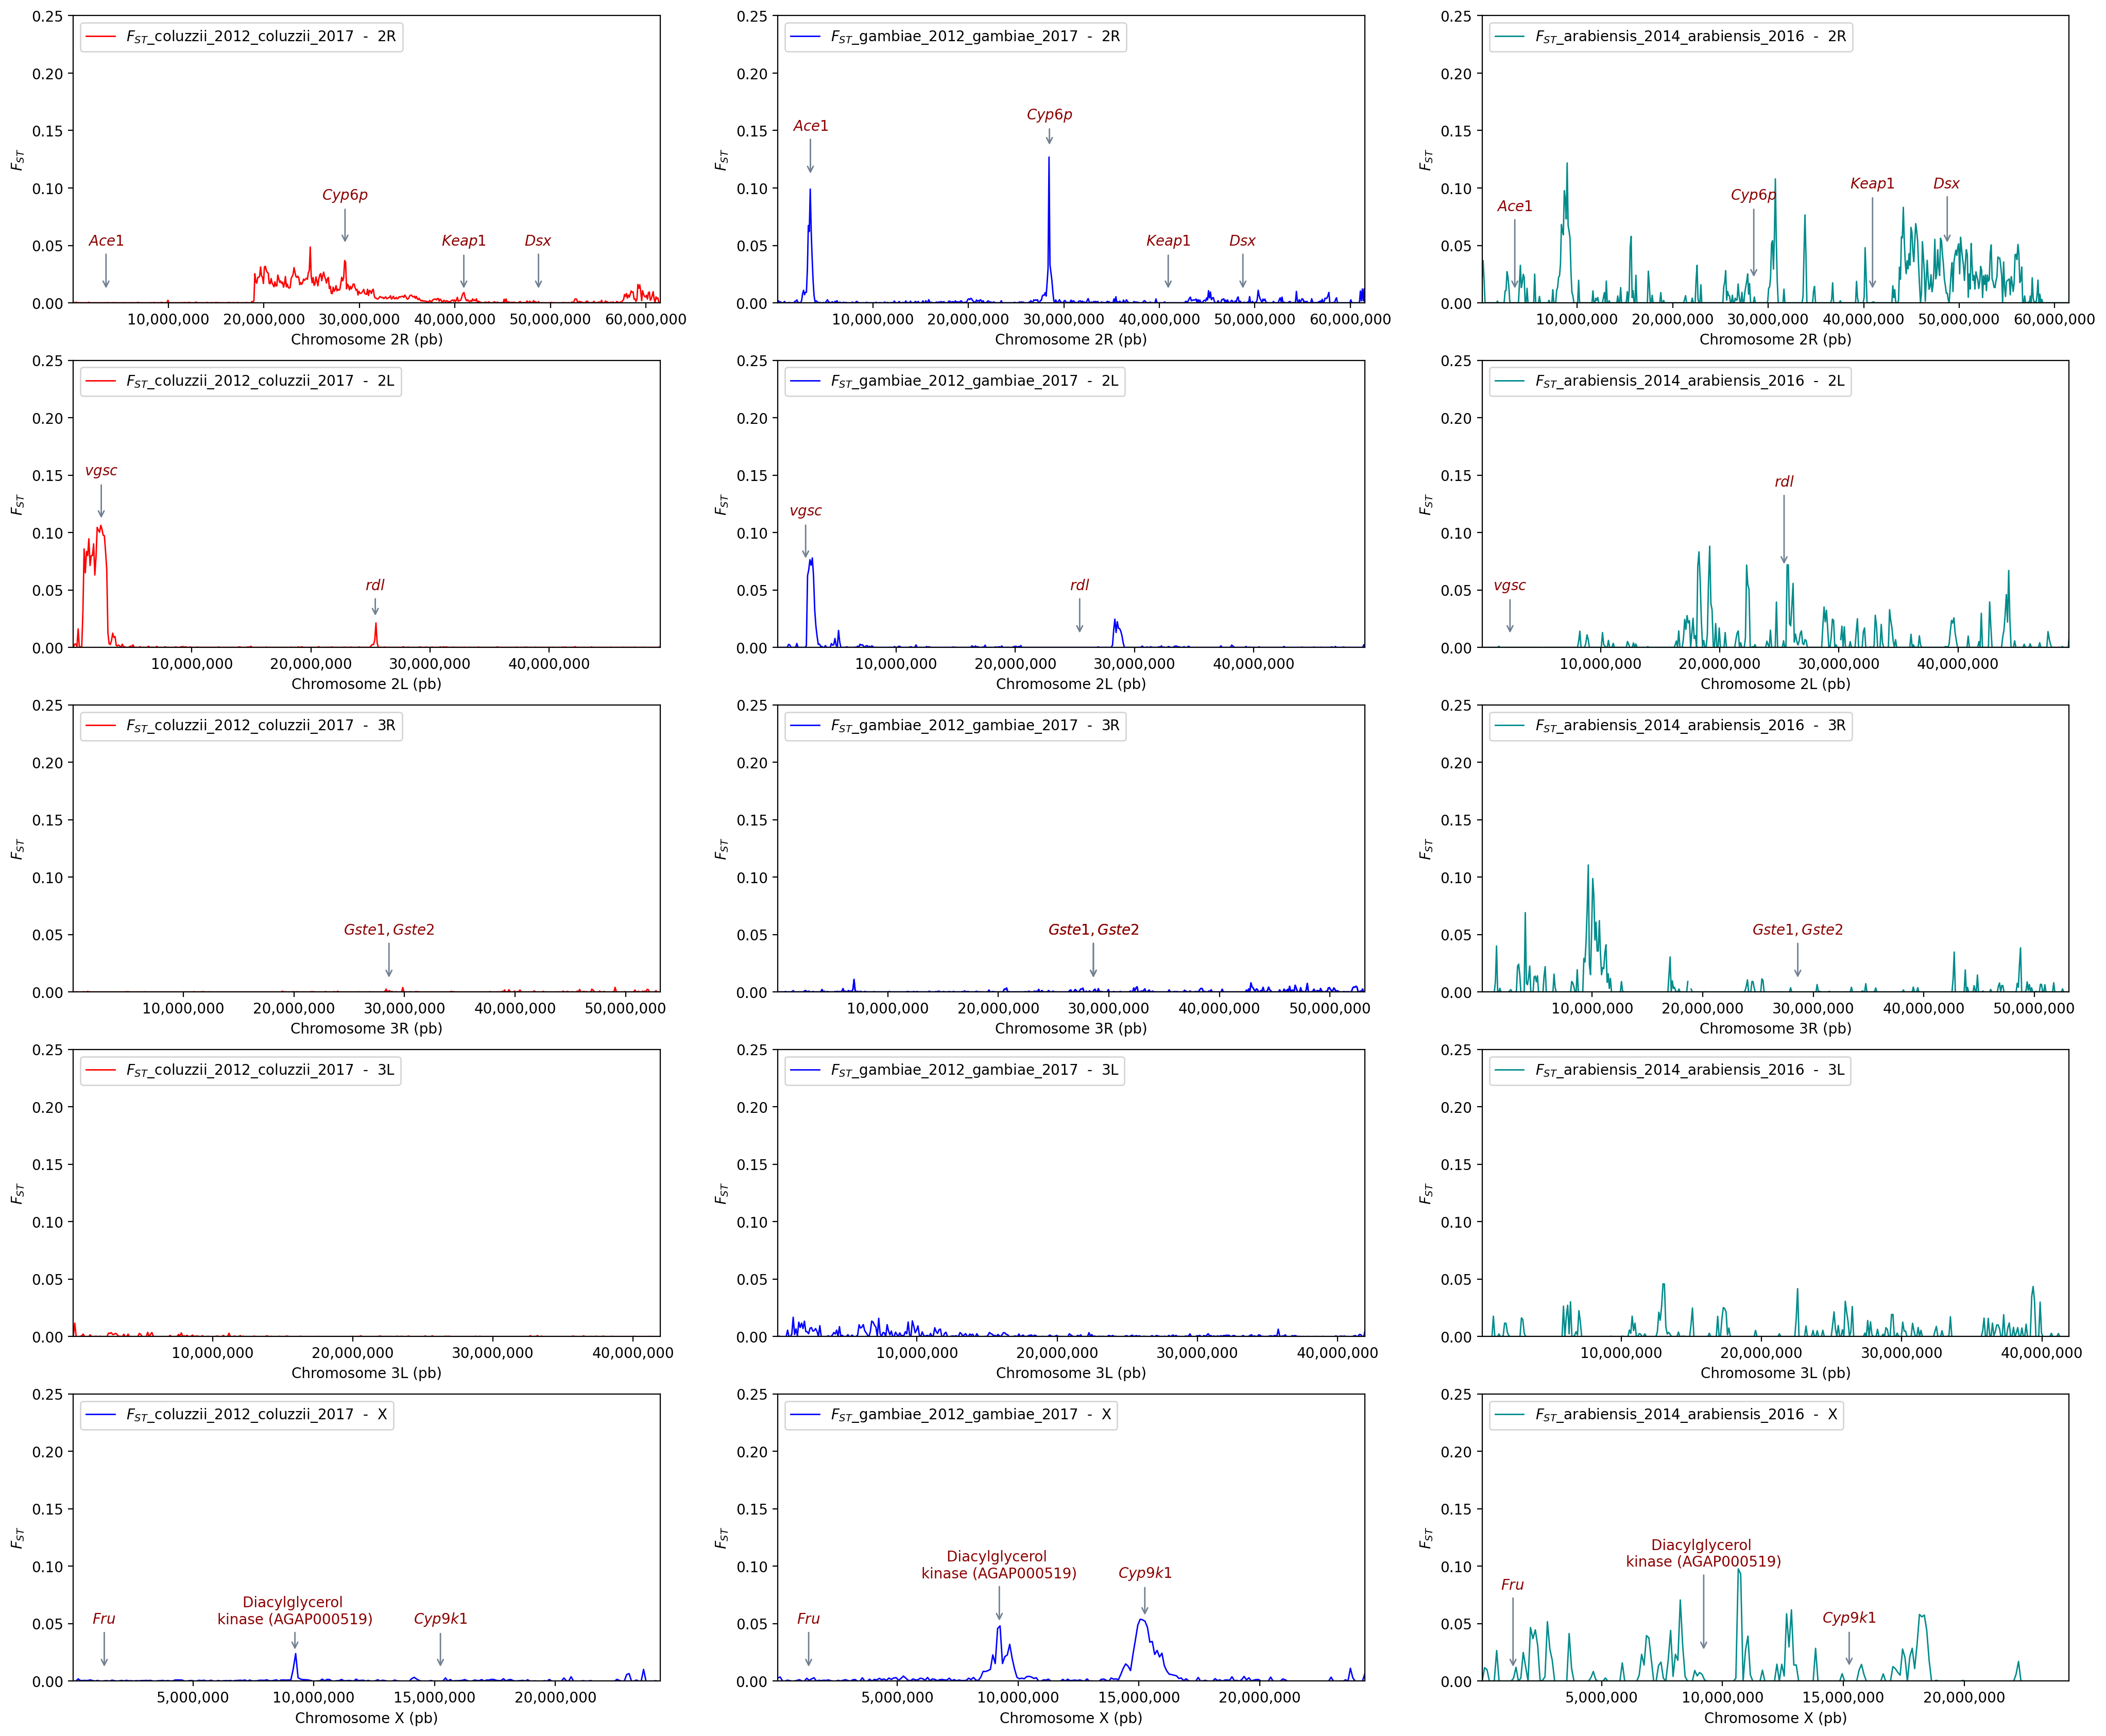

In [78]:
fig, ax = plt.subplots(figsize=(25,21))
gs = GridSpec(5, 3)

ax0 = plt.subplot(gs[0, 0])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax0, xlab='2R', color='red', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(np.mean([3438301, 3497400]), 0.01), xytext=(np.mean([3438301, 3497400]), 0.05), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(np.mean([28491242, 28493314]), 0.05), xytext=(np.mean([28491242, 28493314]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(np.mean([40926764 , 40930610]), 0.01), xytext=(np.mean([40926764 , 40930610]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Dsx$', xy=(np.mean([48703664, 48792262]), 0.01), xytext=(np.mean([48703664, 48792262]), 0.05), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[0, 1])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax1, xlab='2R', color='blue', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(np.mean([3438301, 3497400]), 0.11), xytext=(np.mean([3438301, 3497400]), 0.15), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(np.mean([28491242, 28493314]), 0.135), xytext=(np.mean([28491242, 28493314]), 0.16), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(np.mean([40926764 , 40930610]), 0.01), xytext=(np.mean([40926764 , 40930610]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Dsx$', xy=(np.mean([48703664, 48792262]), 0.01), xytext=(np.mean([48703664, 48792262]), 0.05), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax2 = plt.subplot(gs[0, 2])
fig_Fst(data=fst_stat_2R.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax2, xlab='2R', color='darkcyan', ylab=True)
#plt.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Ace1$', xy=(np.mean([3438301, 3497400]), 0.01), xytext=(np.mean([3438301, 3497400]), 0.08), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Cyp6p$', xy=(np.mean([28491242, 28493314]), 0.02), xytext=(np.mean([28491242, 28493314]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(40926764 , 40930610, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Keap1$', xy=(np.mean([40926764 , 40930610]), 0.01), xytext=(np.mean([40926764 , 40930610]), 0.10), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Dsx$', xy=(np.mean([48703664, 48792262]), 0.05), xytext=(np.mean([48703664, 48792262]), 0.10), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax3 = plt.subplot(gs[1, 0])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax3, xlab='2L', color='red', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(np.mean([2358158, 2431617]), 0.11), xytext=(np.mean([2358158, 2431617]), 0.15),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.025), xytext=(np.mean([25363652, 25434556]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax4 = plt.subplot(gs[1, 1])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax4, xlab='2L', color='blue', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(np.mean([2358158, 2431617]), 0.075), xytext=(np.mean([2358158, 2431617]), 0.115),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.01), xytext=(np.mean([25363652, 25434556]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax5 = plt.subplot(gs[1, 2])
fig_Fst(data=fst_stat_2L.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax5, xlab='2L', color='darkcyan', ylab=True)
#plt.axvspan(2358158, 2431617, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$vgsc$', xy=(np.mean([2358158, 2431617]), 0.01), xytext=(np.mean([2358158, 2431617]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(25363652, 25434556, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$rdl$ ', xy=(np.mean([25363652, 25434556]), 0.07), xytext=(np.mean([25363652, 25434556]), 0.14),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax6 = plt.subplot(gs[2, 0])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax6, xlab='3R', color='red', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax7 = plt.subplot(gs[2, 1])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax7, xlab='3R', color='blue', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax8 = plt.subplot(gs[2, 2])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax8, xlab='3R', color='darkcyan', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax7 = plt.subplot(gs[2, 1])
fig_Fst(data=fst_stat_3R.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax7, xlab='3R', color='blue', ylab=True)
#plt.axvspan(28597652, 28599816, color='magenta', alpha=0.2, lw=0.3)
plt.annotate('$Gste1, Gste2$', xy=(np.mean([28597652, 28599816]), 0.01), xytext=(np.mean([28597652, 28599816]), 0.05),
             color='darkred', arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax9 = plt.subplot(gs[3, 0])
ax9.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax9, xlab='3L', color='red', ylab=True)

ax10 = plt.subplot(gs[3, 1])
ax10.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax10, xlab='3L', color='blue', ylab=True)

ax11 = plt.subplot(gs[3, 2])
ax11.locator_params(axis='x', nbins=5)
fig_Fst(data=fst_stat_3L.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax11, xlab='3L', color='darkcyan', ylab=True)

ax12 = plt.subplot(gs[4, 0])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_coluzzii_2012_coluzzii_2017"'), ax=ax12, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Fru$ ', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.025), xytext=(np.mean([9200001,9240000]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.01), xytext=(np.mean([15240572, 15242864]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax13 = plt.subplot(gs[4, 1])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_gambiae_2012_gambiae_2017"'), ax=ax13, xlab='X', color='blue', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Fru$', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.05), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.05), xytext=(np.mean([9200001,9240000]), 0.09), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.055), xytext=(np.mean([15240572, 15242864]), 0.09), color='darkred',
            arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax14 = plt.subplot(gs[4, 2])
fig_Fst(data=fst_stat_X.query('year_Pop == "fst_arabiensis_2014_arabiensis_2016"'), ax=ax14, xlab='X', color='darkcyan', ylab=True)
#plt.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Fru$ ', xy=(np.mean([1283016, 1373662]), 0.01), xytext=(np.mean([1283016, 1373662]), 0.08), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(9200001,9240000, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('Diacylglycerol \nkinase (AGAP000519)', xy=(np.mean([9200001,9240000]), 0.025), xytext=(np.mean([9200001,9240000]), 0.10), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
plt.annotate('$Cyp9k1$', xy=(np.mean([15240572, 15242864]), 0.011), xytext=(np.mean([15240572, 15242864]), 0.051), color='darkred',
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

fig.savefig(f"drive/MyDrive/Genomic/Fst/yty_Whole_Fst1.png", dpi=300, bbox_inches='tight')